# Instalação das bibliotecas

In [ ]:
!pip install vaderSentiment
!pip install transformers
!pip install torch
!pip install langdetect
!pip install textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=441fa15fe7e8ad6b9b55c833995c3928f5dbd3b6cac7d2b7787367fad10b8fd0
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("GPUs disponíveis: ", gpus)

GPUs disponíveis:  []


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk

nltk.download('punkt')

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

import torch

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Selecionando apenas as letras em inglês

In [ ]:
# BD escolhido para o estudo com as letras já coletadas pelo LyricsGenius
file_path = '/content/drive/MyDrive/TCC/Billboard_Hot100_Songs_with_Lyrics_Sample.csv'
df_init = pd.read_csv(file_path)

def detect_language(lyrics):
    try:
        return detect(lyrics)
    except LangDetectException:
        return None

df_init['language'] = df_init['lyrics'].apply(lambda x: detect_language(x) if isinstance(x, str) else None)

df_init = df_init[df_init['language'] == 'en']

output_path = '/content/Billboard_Hot100_Songs_in_English.csv'
df_init.to_csv(output_path, index=False)

print(f"Arquivo com músicas em inglês salvo em: {output_path}")

Arquivo com músicas em inglês salvo em: /content/Billboard_Hot100_Songs_in_English.csv


# Pré Processamento

In [ ]:
with open('/content/drive/MyDrive/TCC/stopwords-en-.txt') as file:
    stop_words = set(word.strip() for word in file.readlines())

df = pd.read_csv("/content/Billboard_Hot100_Songs_in_English.csv")

def preprocess_lyrics(lyrics):
    if pd.isna(lyrics):
        return ""

    lyrics = lyrics.lower()
    lyrics = re.sub(r'\[.*?\]', '', lyrics)
    lyrics = re.sub(r'\n', ' ', lyrics)
    lyrics = re.sub(r'[^a-zA-Z\s]', '', lyrics)
    lyrics = re.sub(r'\b(\d+\s*contributors?|contributor|contributors|youre|lyrics|embed|song)\b', '', lyrics, flags=re.IGNORECASE)
    lyrics = re.sub(r'contributors', '', lyrics)
    lyrics = re.sub(r'contributor', '', lyrics)
    lyrics = re.sub(r'lyrics', '', lyrics)
    lyrics = lyrics.lower()
    lyrics = ' '.join([word for word in lyrics.split() if word not in stop_words])
    lyrics = re.sub(r'\s+', ' ', lyrics).strip()

    return lyrics

df['clean_lyrics'] = df['lyrics'].apply(preprocess_lyrics)
df = df[df['clean_lyrics'] != ""]

print(df['clean_lyrics'].head())

0    rose remain sun rain lovely promise true belon...
1    gypsy quaint caravan gypsy future drive fears ...
2    minutes evening fast fun kiss garden gate peck...
3    rumors flying rumors flying sighing crazy daze...
4    arabian nights providence guitar chapter monsi...
Name: clean_lyrics, dtype: object


# TOP 20 palavras mais frequentes

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-132-8cbe3fad04c1>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequencies, y=words, palette='viridis')


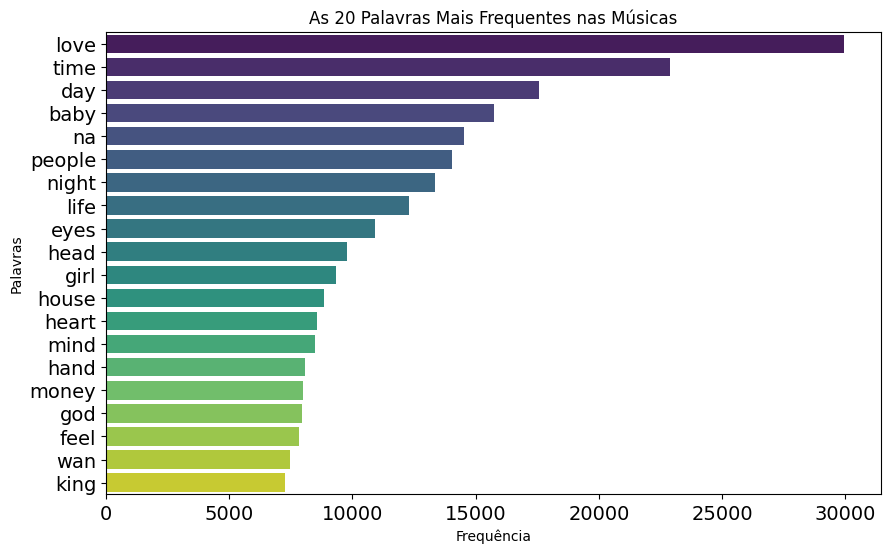

In [ ]:
all_words = []
for lyrics in df['clean_lyrics']:
    words = nltk.word_tokenize(lyrics)
    all_words.extend(words)

# Contando a frequência de cada palavra
word_freq = Counter(all_words)

# Selecionando as 20 palavras mais frequentes
common_words = word_freq.most_common(20)

# Separando as palavras e suas frequências para visualização
words, frequencies = zip(*common_words)

# Visualizando as 20 palavras mais frequentes
plt.figure(figsize=(10, 6))
sns.barplot(x=frequencies, y=words, palette='viridis')
plt.title('As 20 Palavras Mais Frequentes nas Músicas')
plt.xlabel('Frequência')
plt.ylabel('Palavras')
plt.show()

# Separação por década

In [ ]:
def create_decade_dfs(df):
    df['Decade'] = (df['Hot100 Ranking Year'] // 10) * 10
    decades = df['Decade'].unique()
    decade_dfs = {}
    for decade in decades:
        decade_dfs[decade] = df[df['Decade'] == decade].copy()
    return decade_dfs

# Criar os DataFrames separados por décadas
decade_dfs = create_decade_dfs(df)


# TF-IDF e LDA

In [ ]:
stop_words_list = list(stop_words)

def process_decade_lyrics(decade_df, stop_words):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_words_list)
    tfidf_matrix = tfidf_vectorizer.fit_transform(decade_df['clean_lyrics'])

    num_topics = 4
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_topics = lda_model.fit_transform(tfidf_matrix)

    feature_names = tfidf_vectorizer.get_feature_names_out()

    return lda_model, lda_topics, feature_names

# Dicionário para armazenar os resultados por década
decade_results = {}

# Processar TF-IDF e LDA para cada década
for decade, decade_df in decade_dfs.items():
    lda_model, lda_topics, feature_names = process_decade_lyrics(decade_df, stop_words)
    decade_results[decade] = {
        'lda_model': lda_model,
        'lda_topics': lda_topics,
        'feature_names': feature_names
    }


# Gráfico para apenas 1 tópico

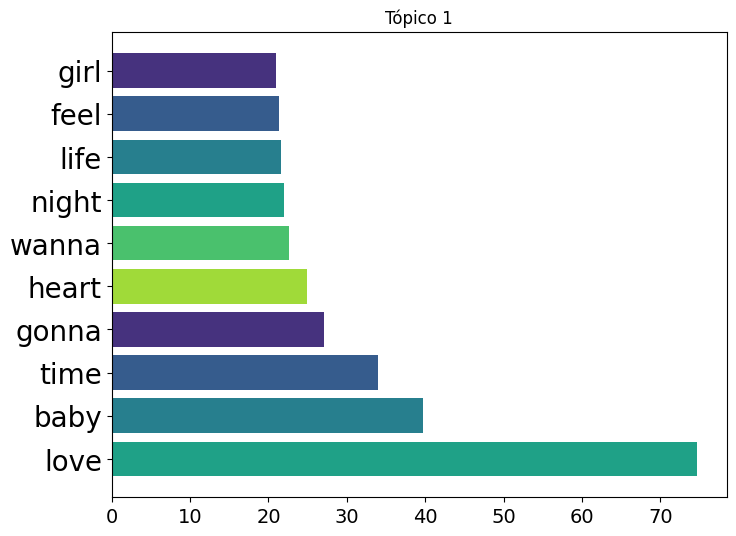

In [ ]:
# Definir a paleta de cores
colors = sns.color_palette("viridis", as_cmap=False)

# Função para gerar gráficos de barras para 1 tópico
def plot_single_topic(lda_model, feature_names, n_top_words=10):
    fig, ax = plt.subplots(figsize=(8, 6))
    topic_words = lda_model.components_[0]
    top_word_indices = topic_words.argsort()[-n_top_words:]
    top_words = [feature_names[i] for i in top_word_indices]
    top_weights = topic_words[top_word_indices]

    y_pos = np.arange(len(top_words))
    ax.barh(y_pos, top_weights, align='center', color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_words, fontsize=20)
    ax.invert_yaxis()
    ax.set_title(f"Tópico 1")

    plt.tight_layout(pad=3.0)
    plt.show()

# Insira a década que deseja visualizar
decade = 1980
lda_model = decade_results[decade]['lda_model']
feature_names = decade_results[decade]['feature_names']

plot_single_topic(lda_model, feature_names)


# Função para gerar 2 tópicos

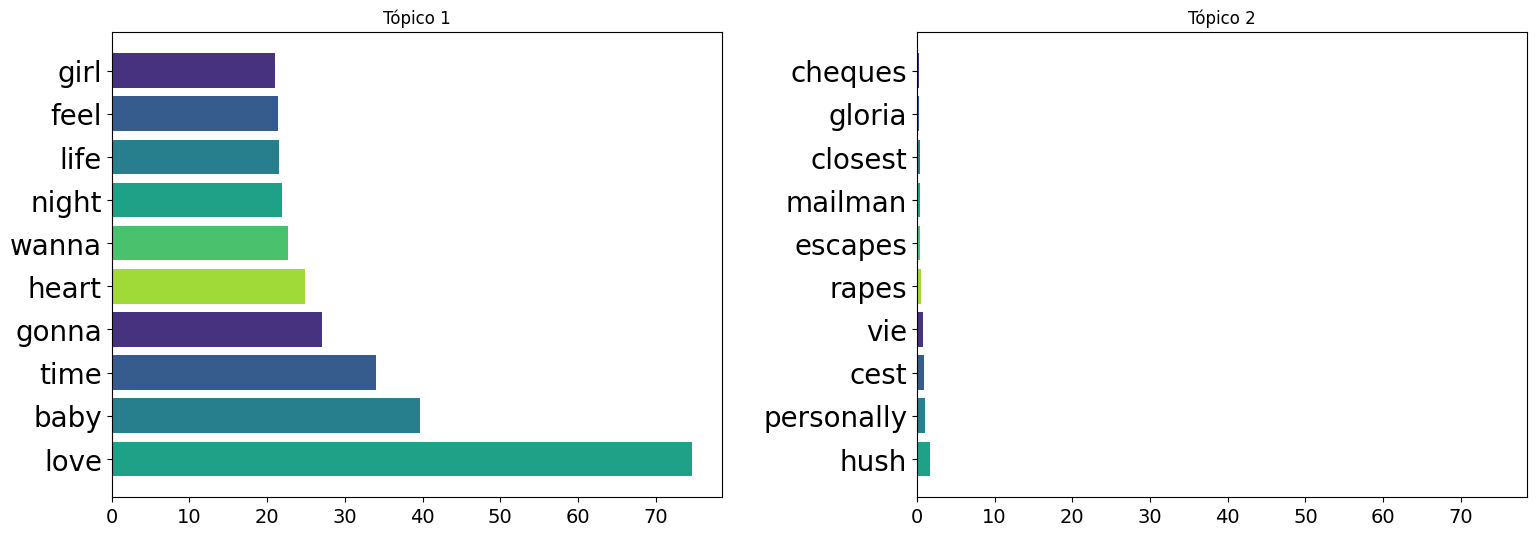

In [ ]:
# Função para gerar gráficos de barras para os tópicos
def plot_two_topics(lda_model, feature_names, n_top_words=10):
    n_topics = 2
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
    axes = axes.flatten()

    for idx, ax in enumerate(axes[:n_topics]):
        topic_words = lda_model.components_[idx]
        top_word_indices = topic_words.argsort()[-n_top_words:]
        top_words = [feature_names[i] for i in top_word_indices]
        top_weights = topic_words[top_word_indices]

        y_pos = np.arange(len(top_words))
        ax.barh(y_pos, top_weights, align='center', color=colors)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_words, fontsize=20)
        ax.invert_yaxis()
        ax.set_title(f"Tópico {idx+1}")

    plt.tight_layout(pad=3.0)
    plt.show()

# Insira a década que deseja visualizar
decade = 1980
lda_model = decade_results[decade]['lda_model']
feature_names = decade_results[decade]['feature_names']

# Gerar gráfico de 2 tópicos
plot_two_topics(lda_model, feature_names)


# Função para gerar 3 tópicos

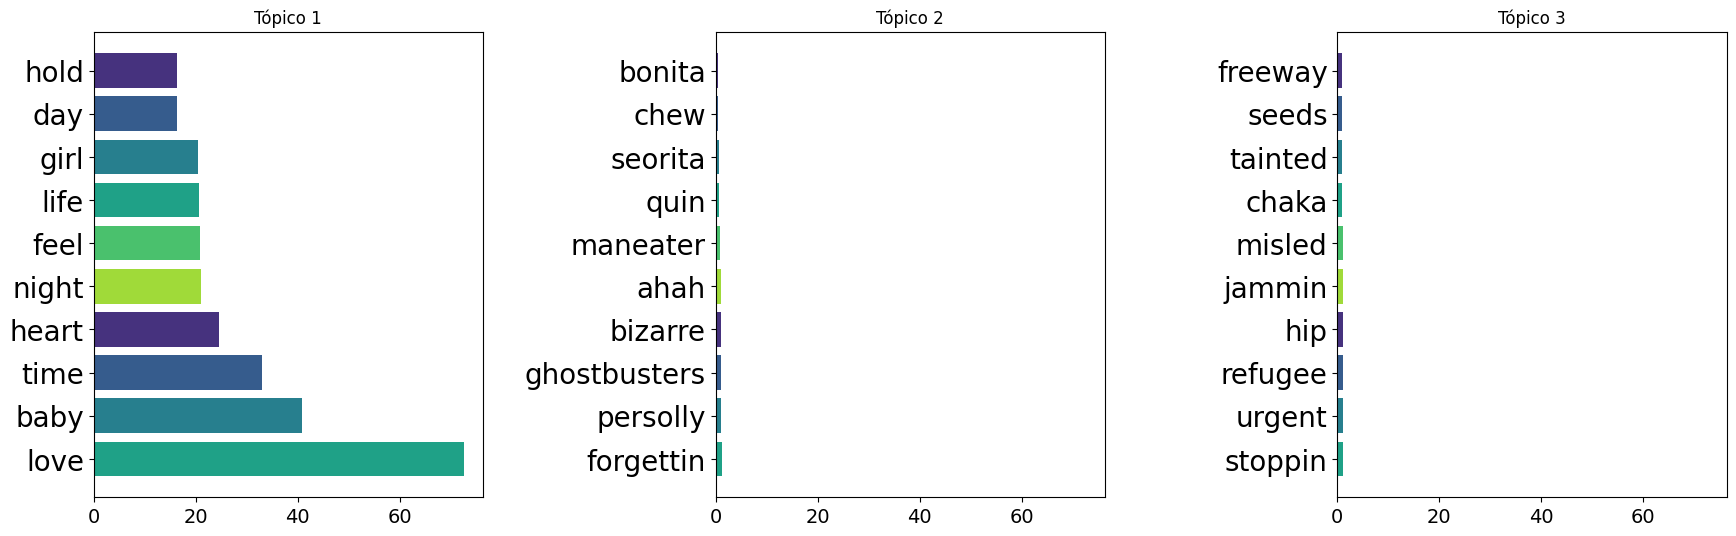

In [ ]:
# Função para gerar gráficos de barras para três tópicos
def plot_three_topics(lda_model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
    axes = axes.flatten()

    for idx, ax in enumerate(axes[:3]):
        topic_words = lda_model.components_[idx]
        top_word_indices = topic_words.argsort()[-n_top_words:]
        top_words = [feature_names[i] for i in top_word_indices]
        top_weights = topic_words[top_word_indices]

        y_pos = np.arange(len(top_words))
        ax.barh(y_pos, top_weights, align='center', color=colors)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_words, fontsize=20)
        ax.invert_yaxis()
        ax.set_title(f"Tópico {idx+1}")

    plt.tight_layout(pad=3.0)
    plt.show()

# Insira a década que deseja visualizar
decade = 1980
lda_model = decade_results[decade]['lda_model']
feature_names = decade_results[decade]['feature_names']

# Gerar gráfico de 3 tópicos
plot_three_topics(lda_model, feature_names)


# Função para gerar 4 tópicos

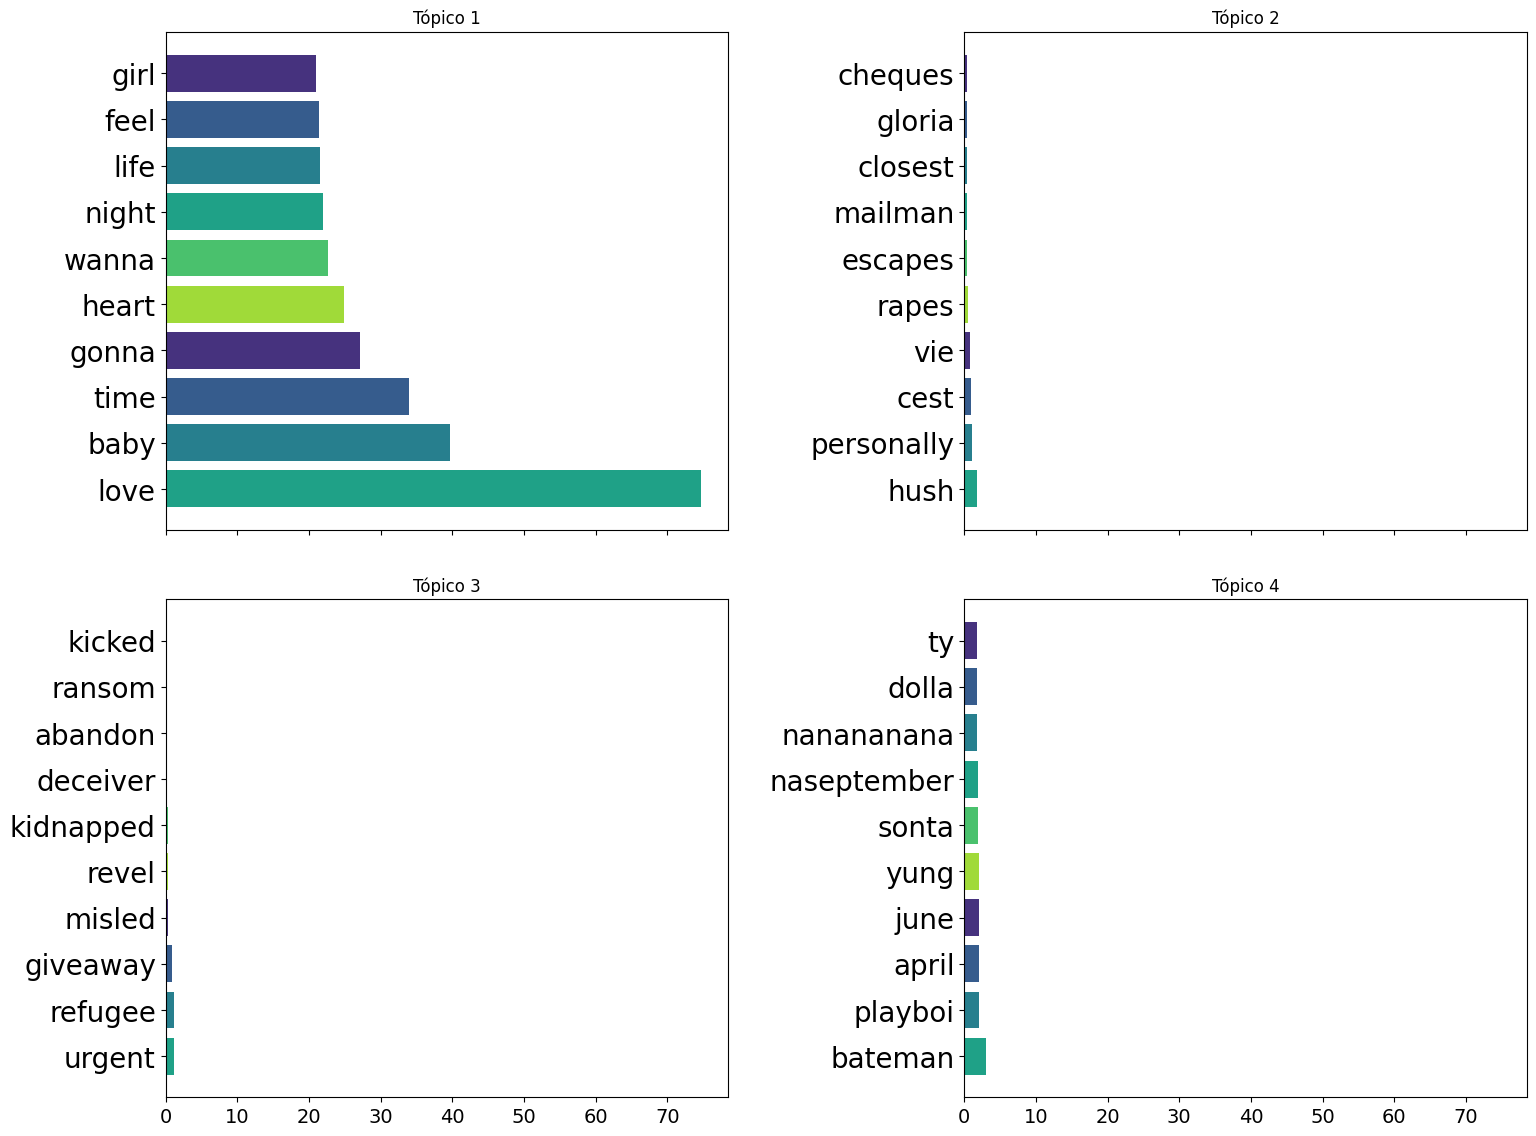

In [ ]:
# Função para gerar gráficos de barras para os tópicos
def plot_multiple_topics(lda_model, feature_names, n_top_words=10):
    n_topics = lda_model.n_components

    fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
    axes = axes.flatten()

    for idx, ax in enumerate(axes[:n_topics]):
        topic_words = lda_model.components_[idx]
        top_word_indices = topic_words.argsort()[-n_top_words:]
        top_words = [feature_names[i] for i in top_word_indices]
        top_weights = topic_words[top_word_indices]

        y_pos = np.arange(len(top_words))
        ax.barh(y_pos, top_weights, align='center', color=colors)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_words, fontsize=20)
        ax.invert_yaxis()
        ax.set_title(f"Tópico {idx+1}")

    plt.tight_layout(pad=3.0)
    plt.show()

# Insira a década que deseja visualizar
decade = 1980
lda_model = decade_results[decade]['lda_model']
feature_names = decade_results[decade]['feature_names']

# Gerar gráfico de 4 tópicos
plot_multiple_topics(lda_model, feature_names)

# Análise de Sentimento

In [ ]:
analyzer = SentimentIntensityAnalyzer()
device = 0 if torch.cuda.is_available() else -1

sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
# Funções de análise de sentimentos
def analyze_sentiment_vader(lyrics):
    sentiment = analyzer.polarity_scores(lyrics)
    return sentiment

def analyze_sentiment_textblob(lyrics):
    blob = TextBlob(lyrics)
    return blob.sentiment

def analyze_sentiment_llm(lyrics, max_length=512):
    chunks = [lyrics[i:i+max_length] for i in range(0, len(lyrics), max_length)]
    sentiments = [sentiment_pipeline(chunk)[0] for chunk in chunks]
    return sentiments

In [ ]:
# Função para categorizar sentimento VADER
def get_polarity_category(vader_sentiment):
    pos = vader_sentiment['pos']
    neu = vader_sentiment['neu']
    neg = vader_sentiment['neg']

    if pos > max(neu, neg):
        return 'Positive'
    elif neg > max(pos, neu):
        return 'Negative'
    elif neu > max(pos, neg):
        return 'Neutral'
    else:
        return 'Mixed'

# Função para categorizar sentimento TextBlob
def get_textblob_category(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [ ]:
# Analisar sentimentos por década
def analyze_sentiments_for_decade(decade_df, decade):
    print(f"Iniciando análise de sentimentos para a década de {decade}...")

    # Inicializar colunas
    sentiment_cols = ['sentiment_vader', 'vader_pos', 'vader_neu', 'vader_neg', 'vader_compound', 'vader_category',
                      'sentiment_textblob', 'textblob_polarity', 'textblob_subjectivity', 'textblob_category',
                      'llm_sentiment', 'llm_sentiment_label', 'llm_sentiment_score']
    for col in sentiment_cols:
        decade_df[col] = None

    # Análise VADER
    total = len(decade_df)
    for i, (index, lyrics) in enumerate(decade_df['clean_lyrics'].items()):
        print(f"Analisando VADER: {i+1}/{total}")
        if isinstance(lyrics, float) and pd.isna(lyrics):
            continue
        sentiment = analyze_sentiment_vader(lyrics)
        decade_df.at[index, 'sentiment_vader'] = sentiment
        decade_df.at[index, 'vader_pos'] = sentiment['pos']
        decade_df.at[index, 'vader_neu'] = sentiment['neu']
        decade_df.at[index, 'vader_neg'] = sentiment['neg']
        decade_df.at[index, 'vader_compound'] = sentiment['compound']
        decade_df.at[index, 'vader_category'] = get_polarity_category(sentiment)

    # Análise TextBlob
    for i, (index, lyrics) in enumerate(decade_df['clean_lyrics'].items()):
        print(f"Analisando TextBlob: {i+1}/{total}")
        if isinstance(lyrics, float) and pd.isna(lyrics):
            continue
        sentiment = analyze_sentiment_textblob(lyrics)
        decade_df.at[index, 'sentiment_textblob'] = sentiment
        decade_df.at[index, 'textblob_polarity'] = sentiment.polarity
        decade_df.at[index, 'textblob_subjectivity'] = sentiment.subjectivity
        decade_df.at[index, 'textblob_category'] = get_textblob_category(sentiment.polarity)

    # Análise LLM
    for i, (index, lyrics) in enumerate(decade_df['clean_lyrics'].items()):
        print(f"Analisando LLM: {i+1}/{total}")
        if isinstance(lyrics, float) and pd.isna(lyrics):
            continue
        sentiments = analyze_sentiment_llm(lyrics)
        max_sentiment = max(sentiments, key=lambda s: s['score'])
        decade_df.at[index, 'llm_sentiment'] = sentiments
        decade_df.at[index, 'llm_sentiment_label'] = max_sentiment['label']
        decade_df.at[index, 'llm_sentiment_score'] = max_sentiment['score']

    # Salvar resultados para a década atual
    filename = f'/content/Billboard_Hot100_Songs_with_Sentiment_{decade}.csv'
    decade_df.to_csv(filename, index=False)
    print(f"Análise de sentimentos para a década de {decade} concluída e salva em {filename}")


In [ ]:
def process_single_decade(decade, decade_dfs):
    # Carregar o dataframe específico para a década fornecida
    if decade in decade_dfs:
        analyze_sentiments_for_decade(decade_dfs[decade], decade)
    else:
        print(f"Década {decade} não encontrada nos dados disponíveis.")

# Insira a década que deseja
decade = 2020
print(process_single_decade(decade, decade_dfs))

print("Análise de sentimentos para a década especificada concluída.")

Iniciando análise de sentimentos para a década de 2020...
Analisando VADER: 1/273
Analisando VADER: 2/273
Analisando VADER: 3/273
Analisando VADER: 4/273
Analisando VADER: 5/273
Analisando VADER: 6/273
Analisando VADER: 7/273
Analisando VADER: 8/273
Analisando VADER: 9/273
Analisando VADER: 10/273
Analisando VADER: 11/273
Analisando VADER: 12/273
Analisando VADER: 13/273
Analisando VADER: 14/273
Analisando VADER: 15/273
Analisando VADER: 16/273
Analisando VADER: 17/273
Analisando VADER: 18/273
Analisando VADER: 19/273
Analisando VADER: 20/273
Analisando VADER: 21/273
Analisando VADER: 22/273
Analisando VADER: 23/273
Analisando VADER: 24/273
Analisando VADER: 25/273
Analisando VADER: 26/273
Analisando VADER: 27/273
Analisando VADER: 28/273
Analisando VADER: 29/273
Analisando VADER: 30/273
Analisando VADER: 31/273
Analisando VADER: 32/273
Analisando VADER: 33/273
Analisando VADER: 34/273
Analisando VADER: 35/273
Analisando VADER: 36/273
Analisando VADER: 37/273
Analisando VADER: 38/273
A

In [ ]:
df_decade = pd.read_csv(f'/content/Billboard_Hot100_Songs_with_Sentiment_{decade}.csv')

print(df_decade[['Song', 'llm_sentiment_label', 'llm_sentiment_score']].head())

                           Song llm_sentiment_label  llm_sentiment_score
0               Blinding Lights            NEGATIVE             0.987624
1                       Circles            NEGATIVE             0.988184
2                       The Box            NEGATIVE             0.998572
3               Don’t Start Now            NEGATIVE             0.990430
4  ROCKSTAR (feat. Roddy Ricch)            NEGATIVE             0.977977


In [ ]:
# Lista de caminhos dos arquivos
file_paths = [
    "/content/drive/MyDrive/TCC/TCC_results/Billboard_Hot100_Songs_with_Sentiment_1940.csv",
    "/content/drive/MyDrive/TCC/TCC_results/Billboard_Hot100_Songs_with_Sentiment_1950.csv",
    "/content/drive/MyDrive/TCC/TCC_results/Billboard_Hot100_Songs_with_Sentiment_1960.csv",
    "/content/drive/MyDrive/TCC/TCC_results/Billboard_Hot100_Songs_with_Sentiment_1970.csv",
    "/content/drive/MyDrive/TCC/TCC_results/Billboard_Hot100_Songs_with_Sentiment_1980.csv",
    "/content/drive/MyDrive/TCC/TCC_results/Billboard_Hot100_Songs_with_Sentiment_1990.csv",
    "/content/drive/MyDrive/TCC/TCC_results/Billboard_Hot100_Songs_with_Sentiment_2000.csv",
    "/content/drive/MyDrive/TCC/TCC_results/Billboard_Hot100_Songs_with_Sentiment_2010.csv",
    "/content/drive/MyDrive/TCC/TCC_results/Billboard_Hot100_Songs_with_Sentiment_2020.csv"
]

# Lista para armazenar os dataframes
dfs = []

# Carregar cada arquivo e adicionar à lista
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

all_decades_df = pd.concat(dfs, ignore_index=True)

# Salvar o DataFrame concatenado em um arquivo CSV
all_decades_df.to_csv('/content/drive/MyDrive/TCC/TCC_results/Billboard_Hot100_Songs_with_Sentiment_All_Decades.csv', index=False)
